# Facial Keypoint Detection

## Import FastAI

In [1]:
from fastai.vision.all import *

## Download Dataset and extract data

In [2]:
!kaggle competitions download -c facial-keypoints-detection

facial-keypoints-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
file_extract("facial-keypoints-detection.zip", dest="./facial-keypoints-ds")

In [4]:
path = Path.cwd()/"facial-keypoints-ds"

In [5]:
path, path.ls()

(Path('/home/gurucharan/workspace/PyTorch/github/Facial-Keypoints-Detection_FastAI2/facial-keypoints-ds'),
 (#4) [Path('/home/gurucharan/workspace/PyTorch/github/Facial-Keypoints-Detection_FastAI2/facial-keypoints-ds/training.zip'),Path('/home/gurucharan/workspace/PyTorch/github/Facial-Keypoints-Detection_FastAI2/facial-keypoints-ds/SampleSubmission.csv'),Path('/home/gurucharan/workspace/PyTorch/github/Facial-Keypoints-Detection_FastAI2/facial-keypoints-ds/IdLookupTable.csv'),Path('/home/gurucharan/workspace/PyTorch/github/Facial-Keypoints-Detection_FastAI2/facial-keypoints-ds/test.zip')])

In [6]:
import glob
all_zips = glob.glob(f"{str(path)}/*.zip")
[file_extract(f"{zip}", dest=f"{str(path)}") for zip in all_zips]

[None, None]

## Verify missing values

In [7]:
df = pd.read_csv(path/"training.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7039 non-null   float64
 1   left_eye_center_y          7039 non-null   float64
 2   right_eye_center_x         7036 non-null   float64
 3   right_eye_center_y         7036 non-null   float64
 4   left_eye_inner_corner_x    2271 non-null   float64
 5   left_eye_inner_corner_y    2271 non-null   float64
 6   left_eye_outer_corner_x    2267 non-null   float64
 7   left_eye_outer_corner_y    2267 non-null   float64
 8   right_eye_inner_corner_x   2268 non-null   float64
 9   right_eye_inner_corner_y   2268 non-null   float64
 10  right_eye_outer_corner_x   2268 non-null   float64
 11  right_eye_outer_corner_y   2268 non-null   float64
 12  left_eyebrow_inner_end_x   2270 non-null   float64
 13  left_eyebrow_inner_end_y   2270 non-null   float

## Preprocess the data

### Drop missing values

Dripping missing values will results in huge reduction in data, so it is not viable option

### Fill missing data
1. Forward fill ```ffill``` works better
2. Fill with median values, results are similar to Forward fill
3. Fill with mean values, doesn't works for smaller faces

I have kept all the options, for experimentation. Feel free to do so!

In [8]:
### Drop missing values
#df = df.dropna()

### Fill with median values or mean values
'''
for c in df.columns:
    if(df[c].dtype!='object'):
        #df[c].fillna(df[c].mean(), inplace=True)
        df[c].fillna((df[c].median()), inplace=True)
'''

### Forward fill
df = df.fillna(method='ffill')

### Other experimentation but not completed!!
#df['is_valid'] = df.isna().sum(axis=1).apply(lambda x: False if x==0 else True)
#df = df.fillna(-1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7049 non-null   float64
 1   left_eye_center_y          7049 non-null   float64
 2   right_eye_center_x         7049 non-null   float64
 3   right_eye_center_y         7049 non-null   float64
 4   left_eye_inner_corner_x    7049 non-null   float64
 5   left_eye_inner_corner_y    7049 non-null   float64
 6   left_eye_outer_corner_x    7049 non-null   float64
 7   left_eye_outer_corner_y    7049 non-null   float64
 8   right_eye_inner_corner_x   7049 non-null   float64
 9   right_eye_inner_corner_y   7049 non-null   float64
 10  right_eye_outer_corner_x   7049 non-null   float64
 11  right_eye_outer_corner_y   7049 non-null   float64
 12  left_eyebrow_inner_end_x   7049 non-null   float64
 13  left_eyebrow_inner_end_y   7049 non-null   float

## Create DataLoaders through DataBlock

In [9]:
### Image construction from array values
def condtruct_image(row):
  return PILImage(Image.fromarray(np.fromstring(row['Image'], sep=' ').astype(np.float32).reshape(-1, 96)).convert("P"))

### Get keypoints
def get_keypoints(r):
  return torch.from_numpy(r.drop('Image').values.astype(np.float32).reshape(-1, 2))

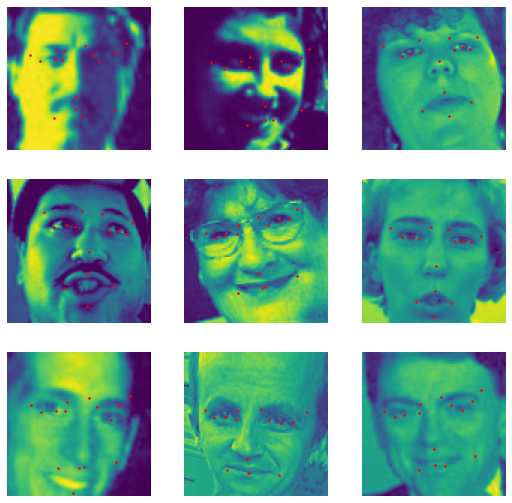

In [10]:
db = DataBlock(
    blocks = (ImageBlock, PointBlock),
    get_x = condtruct_image,
    get_y = get_keypoints,
    splitter = RandomSplitter(valid_pct=0.10, seed=1234),
    batch_tfms = aug_transforms(do_flip=False, max_zoom=1.0),
)
dls = db.dataloaders(df)
dls.show_batch()

## Create Learner instance

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=0.02290867641568184)

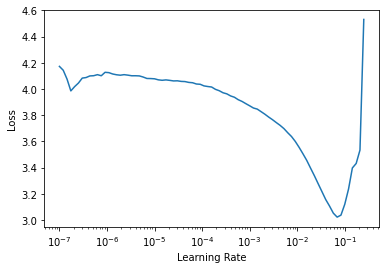

In [11]:
#learn = cnn_learner(dls, resnet50).to_fp16()
learn = cnn_learner(dls, resnet152).to_fp16()
learn.lr_find()

In [12]:
#learn.loss_func
learn.fit_one_cycle(6, 7e-3)

epoch,train_loss,valid_loss,time
0,1.502105,0.317759,00:34
1,0.386146,0.076222,00:34
2,0.206159,0.013521,00:35
3,0.091113,0.021727,00:34
4,0.044066,0.006811,00:35
5,0.029122,0.004889,00:35


## Verify result

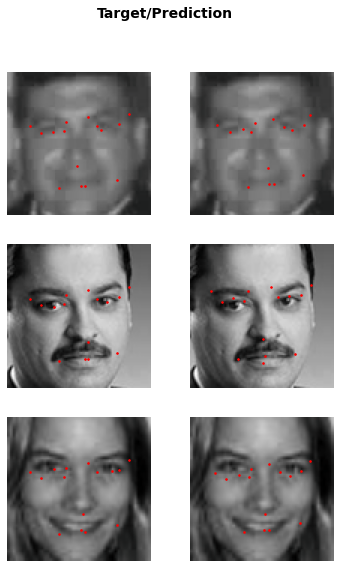

In [13]:
learn.show_results()

## Unfreeze the model and train again

SuggestedLRs(lr_min=2.511886486900039e-06, lr_steep=7.585775847473997e-07)

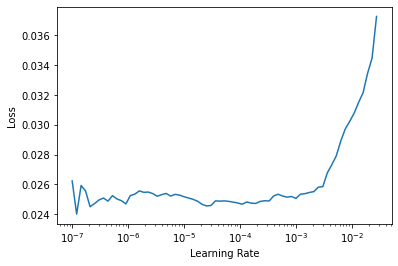

In [14]:
learn.unfreeze()
learn.lr_find()

In [15]:
learn.fit_one_cycle(6, slice(3e-5, 3e-4))

epoch,train_loss,valid_loss,time
0,0.024855,0.005908,00:46
1,0.020980,0.008054,00:46
2,0.016175,0.008006,00:45
3,0.014416,0.003157,00:45
4,0.012976,0.002706,00:45
5,0.011900,0.002639,00:45


## Verify the results

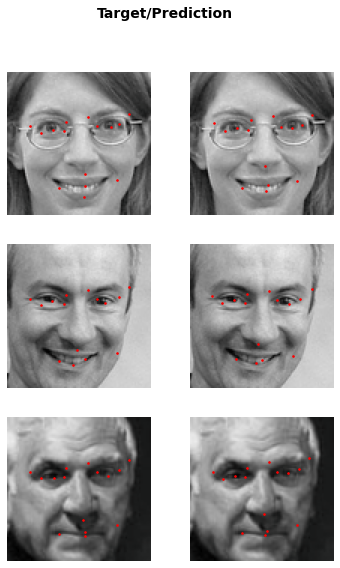

In [16]:
learn.show_results()